In [1]:
import numpy as np
from lab3_proto import *
from lab3_tools import *
import sys  
sys.path.append('/Users/yuhu/Desktop/p4-Speech/Speech-Speaker-Recognition/lab1')
sys.path.append('/Users/yuhu/Desktop/p4-Speech/Speech-Speaker-Recognition/lab2')
from lab1_proto import *
from lab2_proto import *
from prondict import prondict
import re
import gc
import tqdm
from PIL import Image

In [2]:
path2info('tidigits/disc_4.1.1/tidigits/train/man/ae/1a.wav')

('man', 'ae', '1', 'a')

In [3]:
loadAudio('tidigits/disc_4.1.1/tidigits/train/man/ae/z9z6531a.wav')

(array([11, 13, 11, ...,  9,  9,  9], dtype=int16), 20000)

## Target Class Definition

In [4]:
statelist = []
phoneHMMs = np.load('/Users/yuhu/Desktop/p4-Speech/Speech-Speaker-Recognition/lab2/lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
phones = sorted(phoneHMMs.keys())
nstates = {phone:phoneHMMs[phone]['means'].shape[0] for phone in phones}
stateList = [ph + '_' +str(id) for ph in phones for id in range(nstates[ph])]
statelist = stateList 

In [5]:
stateList.index('ay_2')

8

## Forced Alignment

In [6]:
filename ='tidigits/disc_4.1.1/tidigits/train/man/nw/z43a.wav'
samples, samplingrate = loadAudio(filename)
lmfcc = mfcc(samples) 
print(lmfcc.shape)#(length of time frames, number of features)

(178, 13)


In [7]:
wordTrans = list(path2info(filename)[2])
wordTrans

['z', '4', '3']

In [8]:
phoneTrans = words2phones(wordTrans,prondict)
phoneTrans

['sil',
 'z',
 'iy',
 'r',
 'ow',
 'sp',
 'f',
 'ao',
 'r',
 'sp',
 'th',
 'r',
 'iy',
 'sp',
 'sil']

In [9]:
utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)
stateTrans = [phone +'_'+ str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
# stateTrans[10]
print(stateTrans)
print(len(utteranceHMM['name']))

['sil_0', 'sil_1', 'sil_2', 'z_0', 'z_1', 'z_2', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'sp_0', 'f_0', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_2', 'r_0', 'r_1', 'r_2', 'sp_0', 'th_0', 'th_1', 'th_2', 'r_0', 'r_1', 'r_2', 'iy_0', 'iy_1', 'iy_2', 'sp_0', 'sil_0', 'sil_1', 'sil_2']
27


In [10]:
example = np.load('lab3_example.npz',allow_pickle=True)['example'].item()

(178, 39)
(178,)
Correct obsloglik: True
Correct viterbi: True


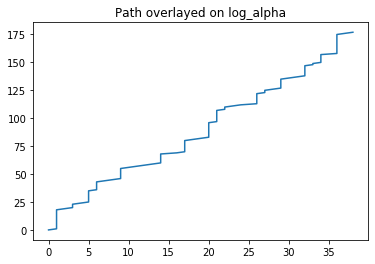

In [11]:
obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
print(obsloglik.shape)# (number of time frames, number of states)
viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']), True)
print(viterbi_path.shape)
plt.plot(viterbi_path, np.arange(len(viterbi_path)))
plt.title("Path overlayed on log_alpha")
print("Correct obsloglik:",np.allclose(obsloglik, example['obsloglik']))
print("Correct viterbi:",np.allclose(viterbi_path, example['viterbiPath']))

In [12]:
viterbiStateTrans = []
for i in range(len(viterbi_path)):
    viterbiStateTrans.append(stateTrans[viterbi_path[i]])
print(viterbiStateTrans)
frames2trans(viterbiStateTrans,outfilename='z43a.lab')

['sil_0', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_1', 'sil_2', 'z_0', 'z_0', 'z_0', 'z_0', 'z_1', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'z_2', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_0', 'iy_1', 'iy_2', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_0', 'r_1', 'r_2', 'ow_0', 'ow_1', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'ow_2', 'f_0', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_1', 'f_2', 'ao_0', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_1', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'ao_2', 'r_0', 'r_0', 'r_0', 'r_1', 'r_2', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_0', 'th_1', 'th_1', 'th_1', 'th_2', 'r_0', 'r

'0 0.01 sil_0\n0.01 0.19000000000000003 sil_1\n0.19000000000000003 0.20000000000000004 sil_2\n0.20000000000000004 0.24000000000000007 z_0\n0.24000000000000007 0.25000000000000006 z_1\n0.25000000000000006 0.36000000000000015 z_2\n0.36000000000000015 0.4400000000000002 iy_0\n0.4400000000000002 0.45000000000000023 iy_1\n0.45000000000000023 0.46000000000000024 iy_2\n0.46000000000000024 0.5600000000000003 r_0\n0.5600000000000003 0.5700000000000003 r_1\n0.5700000000000003 0.5800000000000003 r_2\n0.5800000000000003 0.5900000000000003 ow_0\n0.5900000000000003 0.6000000000000003 ow_1\n0.6000000000000003 0.6900000000000004 ow_2\n0.6900000000000004 0.7000000000000004 f_0\n0.7000000000000004 0.8100000000000005 f_1\n0.8100000000000005 0.8200000000000005 f_2\n0.8200000000000005 0.8300000000000005 ao_0\n0.8300000000000005 0.9700000000000006 ao_1\n0.9700000000000006 1.0800000000000007 ao_2\n1.0800000000000007 1.1100000000000008 r_0\n1.1100000000000008 1.1200000000000008 r_1\n1.1200000000000008 1.13000

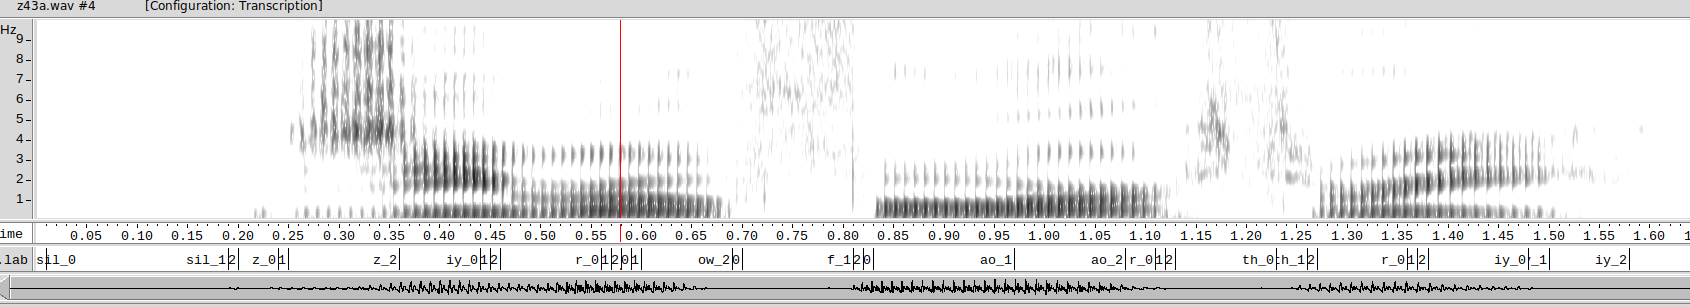

In [13]:
Image.open("align.png")

## Is the alignment correct? what can you say observing the alignment between the sound file and classes?
## (Yes,)

In [16]:
traindata = []
for root, dirs, files in os.walk('tidigits/disc_4.1.1/tidigits/train'): 
  for file in files: 
    if file.endswith('.wav'): 
      filename = os.path.join(root, file) 
      samples, samplingrate = loadAudio(filename) 
      ##...your code for feature extraction and forced alignment
      wordTrans = list(path2info(filename)[2])
      phoneTrans = words2phones(wordTrans, prondict)
      stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
      utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

      lmfcc = mfcc(samples)
      mspecc = mspec(samples)

      obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
      viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']), True)
      targets = [stateList.index(k) for k in list(np.array(stateTrans)[viterbi_path,])]
      traindata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspecc, 'targets': targets})
np.savez('Rawtraindata.npz', traindata=traindata)

In [76]:
a = np.array(['se','ol','lm','wl'])
b = [0,1,1,2,2,2]
c = a[b,]
print(c)

['se' 'ol' 'ol' 'lm' 'lm' 'lm']


In [24]:
# testdata = []
# for root, dirs, files in os.walk('tidigits/disc_4.2.1/tidigits/test'): 
#   for file in files: 
#     if file.endswith('.wav'): 
#       filename = os.path.join(root, file) 
#       samples, samplingrate = loadAudio(filename) 
#       ##...your code for feature extraction and forced alignment
#       wordTrans = list(path2info(filename)[2])
#       phoneTrans = words2phones(wordTrans, prondict)
#       stateTrans = [phone + '_' + str(stateid) for phone in phoneTrans for stateid in range(nstates[phone])]
#       utteranceHMM = concatHMMs(phoneHMMs, phoneTrans)

#       lmfcc = mfcc(samples)
#       mspecc = mspec(samples)

#       obsloglik = log_multivariate_normal_density_diag(lmfcc, utteranceHMM['means'], utteranceHMM['covars'])
#       viterbi_loglik, viterbi_path = viterbi(obsloglik, np.log(utteranceHMM['startprob']), np.log(utteranceHMM['transmat']), True)
#       targets = [stateList.index(k) for k in list(np.array(stateTrans)[viterbi_path,])]
#       testdata.append({'filename': filename, 'lmfcc': lmfcc, 'mspec': mspecc, 'targets': targets})
# np.savez('testdata.npz', testdata=testdata)

## Data split

In [17]:
traindata = np.load("Rawtraindata.npz",allow_pickle=True)
testdata = np.load("testdata.npz",allow_pickle=True)

for k in traindata.iterkeys():
    print(k)
for k in testdata.iterkeys():
    print(k)

traindata
testdata


In [18]:
traindata = np.load("Rawtraindata.npz",allow_pickle=True)['traindata']

In [21]:
np.random.uniform(0,1,1)

array([0.55857855])

In [23]:
#data/tidigits/disc_4.1.1/tidigits/train/man/st/91a.wav
traindata = np.load("Rawtraindata.npz",allow_pickle=1)['traindata']
N= len(traindata)
index = np.random.permutation(N)
X_train,X_val=[],[]
vis = set()
traindata = np.take(traindata,index)
for i in range(N):
  t = np.random.uniform(0,1,1)
  speaker = re.findall("man/.+/",traindata[i]['filename'])[0][4:-1]
  if t >0.9 and speaker not in vis:
    X_val.append(traindata[i])
    vis.add(speaker)
  else: 
    X_train.append(traindata[i])
print("\n")
print(len(X_train),len(X_val))
c = 0
for i in range(len(X_train)):
  c+=1 if 'woman' in X_train[i]['filename'] else 0
print(c,len(X_train)-c)
c = 0
for i in range(len(X_val)):
  c+=1 if 'woman' in X_val[i]['filename'] else 0
print(c,len(X_val)-c)



7740 883
3936 3804
452 431


In [24]:
np.savez('traindata.npz', X_train=X_train)
np.savez('valdata.npz', X_val=X_val)

## Dynamic features preparation

In [25]:
X_train=np.load('traindata.npz',allow_pickle=1)['X_train']
X_val=np.load('valdata.npz',allow_pickle=1)['X_val']
X_test = np.load('testdata.npz',allow_pickle=1)['testdata']

In [43]:
print(X_train[0].keys())#each sample contains keys(filename,lmfcc,mspec,targets)
print(X_train[0]['lmfcc'].shape)#sample's shape after mfcc extracting
print(X_train[0]['lmfcc'][0].shape)#first frame

dict_keys(['filename', 'lmfcc', 'mspec', 'targets'])
(363, 13)
(13,)


In [28]:
def extract_features(X,dynamic=True):
  N = len(X)
  Y=[]
  N_frames = 0

  for i in X:
    N_frames += i['lmfcc'].shape[0]
  if dynamic:
    X_lmfcc =np.zeros((N_frames,X[-1]['lmfcc'][-1].shape[0]*7))
    X_mspec =np.zeros((N_frames,X[-1]['mspec'][-1].shape[0]*7))
  else:
    X_lmfcc =np.zeros((N_frames,X[-1]['lmfcc'][-1].shape[0]))
    X_mspec =np.zeros((N_frames,X[-1]['mspec'][-1].shape[0]))

  f=0
  for i in range(N):
    T=X[i]['lmfcc'].shape[0] #number of timesteps
    if dynamic:
      pad_lmfcc = np.pad(X[i]['lmfcc'],((3,3),(0,0)),'reflect')
      pad_mspec = np.pad(X[i]['mspec'],((3,3),(0,0)),'reflect')
      n = pad_lmfcc.shape[0]
      for t in range(3,n-3):
        # print(X_lmfcc.shape,pad_lmfcc[t-3:t+4].reshape(1,-1).shape)
        X_lmfcc[f]=pad_lmfcc[t-3:t+4].reshape(1,-1)
        X_mspec[f]=pad_mspec[t-3:t+4].reshape(1,-1)
        # print(len(X[i]['targets']))
        Y.append(X[i]['targets'][t-3])
        f+=1
    else:
      for t in range(T):
        X_lmfcc[f]=X[i]['lmfcc'][t].reshape(1,-1)
        X_mspec[f]=X[i]['mspec'][t].reshape(1,-1)
        Y.append(X[i]['targets'][t-3])
        f+=1
  return X_lmfcc,X_mspec, np.array(Y).reshape(-1,1)

In [66]:
a = X_train[0]['lmfcc']
b = np.random.randint(0,10,(2,2))
print(b)
b = np.pad(b,((3,3),(0,0)),'reflect')
print(b)

[[7 9]
 [1 9]]
[[1 9]
 [7 9]
 [1 9]
 [7 9]
 [1 9]
 [7 9]
 [1 9]
 [7 9]]


## Dynamic 

In [67]:
X_train_lmfcc_d, X_train_mspec_d, Y_train=extract_features(X_train)
np.savez('train_dynamic.npz', lmfcc=X_train_lmfcc_d, mspec=X_train_mspec_d, Y=Y_train)
print(X_train_lmfcc_d.shape,X_train_mspec_d.shape,Y_train.shape)

(1354743, 91) (1354743, 280) (1354743, 1)


In [68]:
X_val_lmfcc_d, X_val_mspec_d, Y_val=extract_features(X_val)
np.savez('val_dynamic.npz', lmfcc=X_val_lmfcc_d, mspec=X_val_mspec_d, Y=Y_val)
print(X_val_lmfcc_d.shape,X_val_mspec_d.shape,Y_val.shape)

(152314, 91) (152314, 280) (152314, 1)


In [69]:
X_test_lmfcc_d, X_test_mspec_d, Y_test=extract_features(X_test)
np.savez('test_dynamic.npz', lmfcc=X_test_lmfcc_d, mspec=X_test_mspec_d, Y=Y_test)
print(X_test_lmfcc_d.shape,X_test_mspec_d.shape,Y_test.shape)

(1526682, 91) (1526682, 280) (1526682, 1)


## Non-dynamic

In [70]:
X_train_lmfcc, X_train_mspec, Y_train=extract_features(X_train,False)
np.savez('train_nondynamic.npz', lmfcc=X_train_lmfcc, mspec=X_train_mspec, Y=Y_train)
print(X_train_lmfcc.shape,X_train_mspec.shape,Y_train.shape)

(1354743, 13) (1354743, 40) (1354743, 1)


In [71]:
X_val_lmfcc, X_val_mspec, Y_val=extract_features(X_val,False)
np.savez('val_nondynamic.npz', lmfcc=X_val_lmfcc, mspec=X_val_mspec, Y=Y_val)
print(X_val_lmfcc.shape,X_val_mspec.shape,Y_val.shape)

(152314, 13) (152314, 40) (152314, 1)


In [72]:
X_test_lmfcc, X_test_mspec, Y_test=extract_features(X_test,False)
np.savez('test_nondynamic.npz', lmfcc=X_test_lmfcc, mspec=X_test_mspec, Y=Y_test)
print(X_test_lmfcc.shape,X_test_mspec.shape,Y_test.shape)

(1526682, 13) (1526682, 40) (1526682, 1)
